In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

from collections import defaultdict

import math

import pandas as pd

import optuna

import joblib

import tcn

import HydroErr

from matplotlib import pyplot as plt

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENT = 1758

EPOCHS = 500

train_year = 29 # 29 years of data contained in the train_val splits of the Caravan dataset

PATIENCE = 10

dtypes = defaultdict(lambda: float)
dtypes["catchment_id"] = str

use_amp = True # use Automatic Mixed Precision to speed up training

In [8]:
base_LSTM_study = joblib.load('lstm_base_study.pkl')

In [9]:
class Forcing_Data(Dataset):
    def __init__(
        self,
        fpath="data/Caravan/data_train_w_missing.csv",
        record_length=7304,
        n_feature=3,
    ):
        data_raw = pd.read_csv(fpath, dtype=dtypes)

        # normalization and then reshape to catchment*record*feature
        x = data_raw.loc[:, "P":"PET"]

        x = torch.tensor(x.values, dtype=torch.float32)
        x = x.view(-1, record_length, n_feature)
        self.x = x.to(DEVICE)

        # normalization and then reshape to catchment*record
        y = data_raw["Q"]

        y = torch.tensor(y.values, dtype=torch.float32)
        y = y.view(-1, record_length)
        self.y = y.to(DEVICE)

        self.record_length = self.x.shape[1]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

    def get_random_batch(self):
        # This fuction return a input and output pair for each catchment
        # SEQ_LENGTH, BASE_LENGTH, and DEVICE is from global
        # reference: https://medium.com/@mbednarski/understanding-indexing-with-pytorch-gather-33717a84ebc4
        # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms

        # randomly selects a starting time step for each catchment
        index = torch.randint(
            low=0,
            high=self.record_length - SEQ_LENGTH + 1,
            size=(N_CATCHMENT,),
            device=DEVICE,
        )

        # expand the index to have the length of SEQ_LENGTH, adding 0 to SEQ_LENGTH to get correct index
        index_y = index.unsqueeze(-1).repeat(1, SEQ_LENGTH) + torch.arange(
            SEQ_LENGTH, device=DEVICE
        )
        index_x = index_y.unsqueeze(-1).repeat(1, 1, FORCING_DIM)

        # use gather function to output values
        x_batch, y_batch = self.x.gather(dim=1, index=index_x), self.y.gather(
            dim=1, index=index_y
        )

        return x_batch, y_batch[:, BASE_LENGTH:]

    def get_val_batch(self):
        n_years = math.ceil((self.record_length - BASE_LENGTH) / TARGET_SEQ_LENGTH)

        out_x = (
            torch.ones([n_years, N_CATCHMENT, SEQ_LENGTH, FORCING_DIM], device=DEVICE)
            * torch.nan
        )
        out_y = (
            torch.ones([n_years, N_CATCHMENT, SEQ_LENGTH], device=DEVICE) * torch.nan
        )

        for i in range(n_years):
            start_record_ind = BASE_LENGTH * i

            if i == n_years - 1:
                end_record_ind = self.record_length

                out_x[i, :, 0 : (end_record_ind - start_record_ind), :] = self.x[
                    :, start_record_ind:end_record_ind, :
                ]
                out_y[i, :, 0 : (end_record_ind - start_record_ind)] = self.y[
                    :, start_record_ind:end_record_ind
                ]

            else:
                end_record_ind = start_record_ind + SEQ_LENGTH

                out_x[i, :, :, :] = self.x[:, start_record_ind:end_record_ind, :]
                out_y[i, :, :] = self.y[:, start_record_ind:end_record_ind]

        return out_x, out_y[:, :, BASE_LENGTH:]

In [11]:
dtrain_val = Forcing_Data("data_train_val_w_missing.csv", record_length=10956)
dtest = Forcing_Data("data_test_w_missing.csv", record_length=4017)

In [23]:
class EarlyStopper:
    # Reference: https://stackoverflow.com/a/73704579/3361298

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


# %%
class TimeDistributed(nn.Module):
    # Adatpted from https://discuss.pytorch.org/t/any-pytorch-function-can-work-as-keras-timedistributed/1346/4

    def __init__(self, module, batch_first=False, base_length=BASE_LENGTH):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first
        self.base_length = base_length

    def forward(self, x):

        # subsetting x that the first base_length elements are not interested
        x = x[:, self.base_length :, :]

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(
            -1, x.size(-1)
        )  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(
                x.size(0), -1, y.size(-1)
            )  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y


# %%
class Decoder(nn.Module):
    def __init__(
        self,
        latent_dim,
        feature_dim,
        lstm_hidden_dim,
        fc_hidden_dims,
        num_lstm_layers=1,
        output_dim=1,
        p=0.2,
    ):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.feature_dim = feature_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers

        self.lstm = nn.LSTM(
            self.feature_dim + self.latent_dim,
            self.lstm_hidden_dim,
            num_layers=self.num_lstm_layers,
            batch_first=True,
        )

        # LSTM to latent code
        self.fc_hidden_dims = fc_hidden_dims
        self.fc_layers = []
        self.p = p
        for i in range((len(self.fc_hidden_dims))):
            in_dim = self.lstm_hidden_dim if i == 0 else self.fc_hidden_dims[i - 1]
            out_dim = self.fc_hidden_dims[i]

            self.fc_layers += [nn.Linear(in_dim, out_dim)]
            self.fc_layers += [nn.ReLU()]
            self.fc_layers += [nn.Dropout(p=self.p)]

        self.output_dim = output_dim
        self.fc_layers += [nn.Linear(self.fc_hidden_dims[-1], self.output_dim)]

        self.fc_layers = TimeDistributed(
            nn.Sequential(*self.fc_layers), batch_first=True
        )

    def forward(self, inputs):
        self.out, (_, _) = self.lstm(inputs)
        self.out = self.fc_layers(self.out)

        return self.out

    def decode(self, code, x):
        code = code.expand(x.shape[1], -1, -1).transpose(0, 1)

        x = torch.cat((code, x), 2)
        out = self.forward(x).squeeze()

        return out

    
def mse_loss_with_nans(input, target):
    # Adapted from https://stackoverflow.com/a/59851632/3361298

    # Missing data are nans
    mask = torch.isnan(target)

    out = (input[~mask] - target[~mask]) ** 2
    loss = out.mean()

    return loss


# %%
def val_model(
    embedding, decoder, data, val_metric=mse_loss_with_nans, return_summary=True
):
    """Validate embedding and decoder using the validation batch from dataset and val_metric.

    Args:
        embedding (Embedding): model that map catchment_id (Tensor.int) to latent code [tensor].
        decoder (Decoder): decorder model.
        dataset (Forcing_Data): dataset to be used in validation.
        val_metric (function, optional): compute gof metric. Defaults to mse_loss_with_nans.
        return_summary (bool, optional): whether the gof metric or the raw prediciton should be returned. Defaults to True.
        val_steps(int, optional): Number of catchments evaluated at each steps. Defaults to 500.

    Returns:
        tensor: gof metric or raw prediction.
    """
    x, y = data.get_val_batch()

    embedding.eval()
    decoder.eval()

    preds = torch.ones(size=y.shape).to(DEVICE)

    selected_catchments = torch.arange(N_CATCHMENT).to(DEVICE)

    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
        with torch.no_grad():
            code = embedding(selected_catchments)
            for i in range(x.shape[0]):
                x_sub = x[i, :, :, :]
                preds[i, :, :] = decoder.decode(code, x_sub)

    if return_summary:
        out = val_metric(preds, y)
    else:
        out = (preds, y)

    return out


def define_model(trial):
    lstm_hidden_dim = trial.suggest_int("lstm_hidden_dim", 4, 256)
    n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 2)
    n_fc_layers = trial.suggest_int("n_fc_layers", 1, 3)
    LATENT_DIM_power = trial.suggest_int("LATENT_DIM_power", 1, 2)
    LATENT_DIM = 2**LATENT_DIM_power

    drop_out_flag = trial.suggest_categorical("drop_out_flag", [True, False])

    if drop_out_flag:
        p = trial.suggest_float("dropout_rate", 0.2, 0.5)
    else:
        p = 0

    fc_hidden_dims = []
    for i in range(n_fc_layers):
        fc_dim = trial.suggest_int(f"fc_dim{i}", 4, 32)
        fc_hidden_dims.append(fc_dim)

    decoder = Decoder(
        latent_dim=LATENT_DIM,
        feature_dim=FORCING_DIM,
        lstm_hidden_dim=lstm_hidden_dim,
        fc_hidden_dims=fc_hidden_dims,
        num_lstm_layers=n_lstm_layers,
        output_dim=1,
        p=p,
    )

    embedding = nn.Embedding(N_CATCHMENT, LATENT_DIM)

    return embedding, decoder


In [13]:
def get_optimal_epochs(study):
    
    stats = study.best_trials[0].intermediate_values
    EPOCHS = min(stats, key=lambda k: stats[k]) + 1
    
    return EPOCHS

In [15]:
def get_final_models(study = base_LSTM_study, dataset = dtrain_val, train_year = 29):
    
    # optimal EPOCHS
    EPOCHS = get_optimal_epochs(study)
    trial = study.best_trials[0]

    # define model
    embedding, decoder = define_model(trial)
    embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

    # define optimizers
    lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

    lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)
    
    # amp Scaler
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # define batch size
    batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
    batch_size = 2**batch_size_power
    
    # train model
    for epoch in range(EPOCHS):
        # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
        # repeat TRAIN_YEAR times to finish an epoch
        decoder.train()
        embedding.train()

        for year in range(train_year):

            x_batch, y_batch = dataset.get_random_batch()
            catchment_index = torch.randperm(N_CATCHMENT).to(DEVICE)  # add randomness

            # interate over catchments
            for i in range(int(N_CATCHMENT / batch_size)):

                # prepare data
                ind_s = i * batch_size
                ind_e = (i + 1) * batch_size

                selected_catchments = catchment_index[ind_s:ind_e]

                x_sub, y_sub = x_batch[ind_s:ind_e, :, :], y_batch[ind_s:ind_e, :]

                # prepare training, put the models into training mode
                decoder_optimizer.zero_grad()
                embedding_optimizer.zero_grad()

                # forward pass
                with torch.autocast(
                    device_type="cuda", dtype=torch.float16, enabled=use_amp
                ):
                    code = embedding(selected_catchments)
                    out = decoder.decode(code, x_sub)

                    # backprop
                    loss = mse_loss_with_nans(out, y_sub)

                scaler.scale(loss).backward()
                scaler.step(embedding_optimizer)
                scaler.step(decoder_optimizer)
                scaler.update()
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    return embedding, decoder


In [17]:
embedding, decoder = get_final_models(study=base_LSTM_study, dataset=dtrain_val, train_year=29)

In [18]:
torch.save(embedding.cpu(), "lstm_embedding.pt")
torch.save(decoder.cpu(), "lstm_decoder.pt")

In [19]:
embedding = torch.load("lstm_embedding.pt", map_location=torch.device('cpu'))
decoder = torch.load("lstm_decoder.pt", map_location=torch.device('cpu'))
embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

In [24]:
preds, y_true = val_model(embedding, decoder, dtest, return_summary = False)

In [25]:
preds.shape, y_true.shape

(torch.Size([11, 1758, 365]), torch.Size([11, 1758, 365]))

In [26]:
preds2 = torch.ones([preds.shape[1], preds.shape[0]*preds.shape[2]])*np.nan
y_true2 = torch.ones([preds.shape[1], preds.shape[0]*preds.shape[2]])*np.nan

In [27]:
y_true2.shape, preds2.shape

(torch.Size([1758, 4015]), torch.Size([1758, 4015]))

In [28]:
for i in range(preds.shape[0]):
    ind_s = preds.shape[2]*i
    ind_e = preds.shape[2]*(i+1)
    
    preds2[:,ind_s:ind_e] = preds[i,:,:]
    y_true2[:,ind_s:ind_e] = y_true[i,:,:]

In [29]:
preds2 = preds2.numpy()
y_true2 = y_true2.numpy()

In [30]:
nse = np.ones(preds2.shape[0])
kges = np.ones(preds2.shape[0])
rmse = np.ones(preds2.shape[0])

for i in range(preds2.shape[0]):
    nse[i] = HydroErr.nse(simulated_array=preds2[i,:], observed_array=y_true2[i,:],)
    kges[i] = HydroErr.kge_2009(simulated_array=preds2[i,:], observed_array=y_true2[i,:])
    rmse[i] = HydroErr.rmse(simulated_array=preds2[i,:], observed_array=y_true2[i,:])

/root/miniconda3/lib/python3.8/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [1461 1462 1463 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
/root/miniconda3/lib/python3.8/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [ 251 1461 1462 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
/root/miniconda3/lib/python3.8/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [ 630  631  632 ... 4012 4013 4014] contained NaN values and the row(s) have been removed (Rows are zero indexed).
  warnings.warn("Row(s) {} contained NaN values and the row(s) have been "
/root/miniconda3/lib/python3.8/site-packages/HydroErr/HydroErr.py:6248: UserWarning: Row(s) [ 145 1461 1462 ... 4012 4013 4014] contained NaN values and t

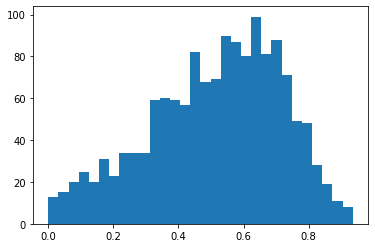

In [31]:
plt.hist(nse[nse>0], bins = 30)
plt.show()

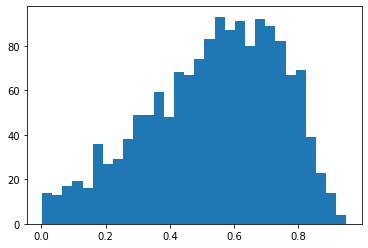

In [32]:
plt.hist(kges[kges>0], bins = 30)
plt.show()

In [38]:
np.isnan(kges)

array([False, False, False, ..., False, False, False])

In [39]:
kges(torch.isnan(kges))

TypeError: isnan(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [55]:
len(kges[~np.isnan(kges)]), len(nse[~np.isnan(nse)])

(1757, 1758)

In [41]:
nse[~np.isnan(nse)].mean()

-inf

In [42]:
invalid_preds = preds2[np.isnan(nse),:]
invalid_ytrue = y_true2[np.isnan(nse),:]

In [43]:
invalid_preds.shape, invalid_ytrue.shape

((0, 4015), (0, 4015))

In [44]:
print(kges)

[0.53357099 0.28873768 0.3215756  ... 0.00256349 0.49605306 0.06812111]


In [45]:
preds.shape

torch.Size([11, 1758, 365])

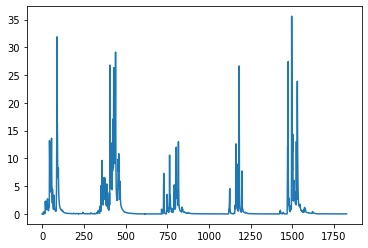

In [51]:
plt.plot(dtest.y.cpu().numpy()[1,0:10000])

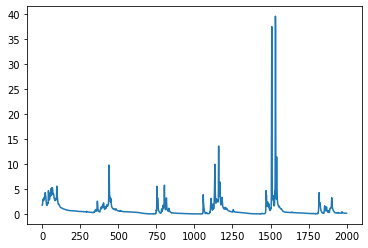

In [52]:
plt.plot(preds2[1,0:2000])

In [39]:
preds2.shape

(1758, 4015)